In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 21 16:34:31 2023

@author: dinglin
"""

import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [2]:
import os
!nvidia-smi

Tue Oct 24 23:47:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1A:00.0 Off |                  N/A |
| 22%   38C    P8    20W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 22%   

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
# Preprocess game frames
def preprocess(frame):
    frame = frame[35:195]
    frame = frame[::2,::2,0]
    frame[frame == 144] = 0
    frame[frame == 109] = 0
    frame[frame != 0] = 1
    return np.reshape(frame.astype(np.float32), 6400)

In [5]:
def smoothing_plot(rewards, window = 99, save = False):
    # Sample rewards data (replace this with your actual rewards)
    episodes = list(range(1, len(rewards)+1))

    # Apply a smoothing filter (Savitzky-Golay filter) to the rewards
    smoothed_rewards = savgol_filter(rewards, window, 3)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, label='Original Rewards', color='lightgray', alpha=0.7)
    plt.plot(episodes, smoothed_rewards, label='Smoothed Rewards', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode with Smoothing')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig("rewards.pdf")
    plt.show()

## Policy Network and Value Network

In [6]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(PolicyNetwork, self).__init__()
        # memories
        self.ep_obs, self.ep_as, self.ep_rs, self.log_p = [], [], [], []
        # parameters
        self.gamma = 0.99
        # neural networks
        self.layer1 = nn.Linear(n_inputs, 200)
        self.layer2 = nn.Linear(200, n_outputs)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        x = self.softmax(x)
        return x
    
class ValueNetwork(nn.Module):
    def __init__(self, n_inputs):
        super(ValueNetwork, self).__init__()
        # neural networks
        self.layer1 = nn.Linear(n_inputs, 100)
        self.layer2 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.output(x)

## Policy Gradient with Baseline

In [7]:
class PolicyGradient():
    def __init__(self, n_inputs, n_outputs, lr_p, lr_v, gamma):
        self.action_size = n_outputs
        self.p_net = PolicyNetwork(n_inputs, n_outputs).to(device)
        self.v_net = ValueNetwork(n_inputs).to(device)
        self.a_optimizer = optim.Adam(self.p_net.parameters(), lr=lr_p)
        self.v_optimizer = optim.Adam(self.v_net.parameters(), lr=lr_v)
        self.gamma = gamma
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.p_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list):
        
        #turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1,-1,-1):
            g_return = reward_list[i] + self.gamma*g_return
            return_array[i] = g_return
            
        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)
        
        # get value function estimates
        vf_t = self.v_net(state_t).to(device)
        with torch.no_grad():
            advantage_t = return_t - vf_t
        
        # calculate actor loss
        selected_action_prob = self.p_net(state_t).gather(1, action_t)
        # REINFORCE loss:
        #actor_loss = torch.mean(-torch.log(selected_action_prob) * return_t)
        # REINFORCE Baseline loss:
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)
        self.a_optimizer.zero_grad()
        actor_loss.backward()
        self.a_optimizer.step() 

        # calculate vf loss
        loss_fn = nn.MSELoss()
        vf_loss = loss_fn(vf_t, return_t)
        self.v_optimizer.zero_grad()
        vf_loss.backward()
        self.v_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()

## Cart-Pole Simulation

In [16]:
# key functions of Gym
env = gym.make('CartPole-v0')

# Initialize RL agent
RL_cart = PolicyGradient(4,2,1e-3,1e-3,0.95)

rewards = []
stats_rewards_list = []
# Roll out 1000 episodes
for episode in range(1000):    
    # Initiate one episode
    observation, info = env.reset()
    episode_length = 0
    stats_actor_loss, stats_vf_loss = 0., 0.
    
    state_list, action_list, reward_list = [], [], []

    terminated = False
    truncated = False

    # Roll out one episode
    while (not terminated) and (not truncated):
        #action = env.action_space.sample() # Use your policy here
        #observation = torch.from_numpy(observation).to(device)
        #p = RL_cart(observation)
        action = RL_cart.select_action(observation)
        next_observation, reward, terminated, truncated, _  = env.step(int(action))

        # store agent's trajectory
        state_list.append(observation)
        action_list.append(action)
        reward_list.append(reward)
        
        observation = next_observation
    
    ep_rs_sum = sum(reward_list)
    actor_loss, vf_loss = RL_cart.train(state_list, action_list, reward_list)
    stats_rewards_list.append((episode, ep_rs_sum, episode_length))
    stats_actor_loss += actor_loss
    stats_vf_loss += vf_loss
    rewards.append(ep_rs_sum)
     
    if episode % 10 == 0:
        print('Episode: {}'.format(episode),
            'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-10:],axis=0)[1]),
            'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-10:],axis=0)[2]),
            'Actor Loss: {:.4f}'.format(stats_actor_loss/10), 
            'VF Loss: {:.4f}'.format(stats_vf_loss/10))
        stats_actor_loss, stats_vf_loss = 0., 0.

    if 'running_reward' not in globals():
        running_reward = ep_rs_sum
    else:
        running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
    total_reward = 0
    episode_length = 0 
    
env.close()

/nfs/home/dxk9547/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/nfs/home/dxk9547/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 Total reward: 13.0 Episode length: 0.0 Actor Loss: 0.4099 VF Loss: 4.2291
Episode: 10 Total reward: 19.6 Episode length: 0.0 Actor Loss: 0.2629 VF Loss: 2.0841
Episode: 20 Total reward: 19.0 Episode length: 0.0 Actor Loss: 0.3000 VF Loss: 2.8411
Episode: 30 Total reward: 17.0 Episode length: 0.0 Actor Loss: 0.4814 VF Loss: 6.3372
Episode: 40 Total reward: 18.5 Episode length: 0.0 Actor Loss: 0.4840 VF Loss: 6.9657
Episode: 50 Total reward: 23.4 Episode length: 0.0 Actor Loss: 0.4542 VF Loss: 6.4991
Episode: 60 Total reward: 23.6 Episode length: 0.0 Actor Loss: 0.1673 VF Loss: 2.4990
Episode: 70 Total reward: 25.6 Episode length: 0.0 Actor Loss: 0.2672 VF Loss: 4.5873
Episode: 80 Total reward: 41.3 Episode length: 0.0 Actor Loss: 0.5239 VF Loss: 9.1546
Episode: 90 Total reward: 36.8 Episode length: 0.0 Actor Loss: -0.1148 VF Loss: 1.6943
Episode: 100 Total reward: 45.3 Episode length: 0.0 Actor Loss: 0.2011 VF Loss: 4.0190
Episode: 110 Total reward: 45.4 Episode length: 0.0 A

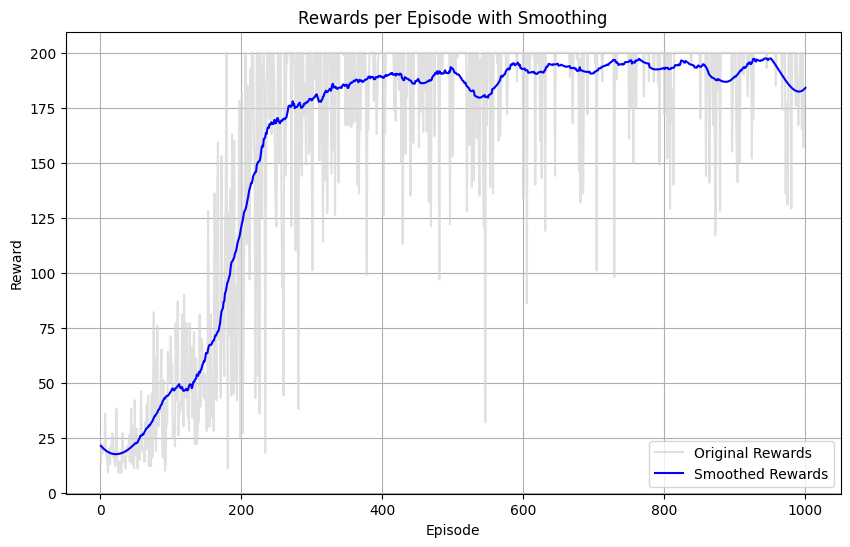

In [17]:
from scipy.signal import savgol_filter
smoothing_plot(rewards, window = 99, save = False)

In [26]:
RL_cart.p_net.eval()
RL_cart.v_net.eval()

# key functions of Gym
env = gym.make('CartPole-v0')

test_rewards = []
for episode in range(500):
    # Initiate one episode
    observation, info = env.reset()
    reward_list = []
    
    terminated = False
    truncated = False

    # Roll out one episode
    while (not terminated) and (not truncated):
        action = RL_cart.select_action(observation)
        next_observation, reward, terminated, truncated, _  = env.step(int(action))
        
        observation = next_observation
        reward_list.append(reward)
    ep_rs_sum = sum(reward_list)
    test_rewards.append(ep_rs_sum)
    if episode % 10 == 0:
        print("Episode: {}".format(episode),
            'Total reward: {:.1f}'.format(np.mean(test_rewards[-10:])))
    
env.close()

Episode: 0 Total reward: 156.0
Episode: 10 Total reward: 171.9
Episode: 20 Total reward: 166.4
Episode: 30 Total reward: 172.7
Episode: 40 Total reward: 180.2
Episode: 50 Total reward: 173.7
Episode: 60 Total reward: 174.9
Episode: 70 Total reward: 172.1
Episode: 80 Total reward: 166.6
Episode: 90 Total reward: 176.1
Episode: 100 Total reward: 176.9
Episode: 110 Total reward: 179.9
Episode: 120 Total reward: 170.9
Episode: 130 Total reward: 172.0
Episode: 140 Total reward: 179.2
Episode: 150 Total reward: 170.3
Episode: 160 Total reward: 164.7
Episode: 170 Total reward: 182.7
Episode: 180 Total reward: 161.3
Episode: 190 Total reward: 182.1
Episode: 200 Total reward: 182.2
Episode: 210 Total reward: 168.8
Episode: 220 Total reward: 169.9
Episode: 230 Total reward: 167.3
Episode: 240 Total reward: 190.0
Episode: 250 Total reward: 171.3
Episode: 260 Total reward: 173.1
Episode: 270 Total reward: 174.1
Episode: 280 Total reward: 177.2
Episode: 290 Total reward: 185.0
Episode: 300 Total re

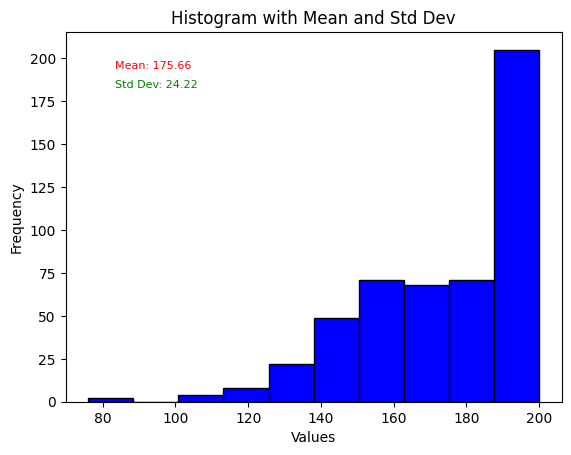

In [31]:
# Create a histogram
plt.hist(test_rewards, bins=10, color='blue', edgecolor='black')

# Calculate mean and standard deviation
mean = np.mean(test_rewards)
std_dev = np.std(test_rewards)

# Customize the histogram
plt.title('Histogram with Mean and Std Dev')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display mean and standard deviation as text labels on the plot
plt.text(0.1, 0.9, f'Mean: {mean:.2f}', fontsize=8, color='red', transform=plt.gca().transAxes)
plt.text(0.1, 0.85, f'Std Dev: {std_dev:.2f}', fontsize=8, color='green', transform=plt.gca().transAxes)

# Show the histogram
plt.show()

## Pong Game Simulation

In [ ]:
env = gym.make("Pong-v0")

RL_pong = PolicyGradient(6400,2,1e-3,1e-3,0.99)
rewards = []
for episode in range(2000):
    # Initiate one episode
    observation, info = env.reset()
    episode_length = 0
    stats_actor_loss, stats_vf_loss = 0., 0.
    
    state_list, action_list, reward_list = [], [], []

    terminated = False
    truncated = False

    # Roll out one episode
    while (not terminated) and (not truncated):
        #action = env.action_space.sample() # Use your policy here
        observation = preprocess(observation)
        action = RL_pong.select_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action+2)

        # store agent's trajectory
        state_list.append(observation)
        action_list.append(action)
        reward_list.append(reward)
        
        observation = next_observation

    ep_rs_sum = sum(reward_list)

    if 'running_reward' not in globals():
        running_reward = ep_rs_sum
    else:
        running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
        
    actor_loss, vf_loss = RL_pong.train(state_list, action_list, reward_list)
    stats_rewards_list.append((episode, ep_rs_sum, episode_length))
    stats_actor_loss += actor_loss
    stats_vf_loss += vf_loss
    total_reward = 0
    episode_length = 0
    
    rewards.append(ep_rs_sum)
    if episode % 10 == 0:
        print('Episode: {}'.format(episode),
            'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-10:],axis=0)[1]),
            'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-10:],axis=0)[2]),
            'Actor Loss: {:.4f}'.format(stats_actor_loss/10), 
            'VF Loss: {:.4f}'.format(stats_vf_loss/10))
        stats_actor_loss, stats_vf_loss = 0., 0.
    if episode % 100 == 0:
        np.save('./rewards_base.npy', rewards)
        model_file_name_p = f"p_model_episode_{episode}.pth"
        model_file_name_v = f"v_model_episode_{episode}.pth"
        torch.save(RL_pong.p_net.state_dict(), '/nfs/home/dxk9547/iems469/assignment1/model/'+model_file_name_p)
        torch.save(RL_pong.v_net.state_dict(), '/nfs/home/dxk9547/iems469/assignment1/model/'+model_file_name_v)
        

/nfs/home/dxk9547/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/nfs/home/dxk9547/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 Total reward: 162.8 Episode length: 0.0 Actor Loss: -0.1118 VF Loss: 0.2944
Episode: 10 Total reward: -20.5 Episode length: 0.0 Actor Loss: -0.0562 VF Loss: 0.0988
Episode: 20 Total reward: -19.9 Episode length: 0.0 Actor Loss: 0.0085 VF Loss: 0.0358
Episode: 30 Total reward: -20.0 Episode length: 0.0 Actor Loss: 0.0047 VF Loss: 0.0475
Episode: 40 Total reward: -20.2 Episode length: 0.0 Actor Loss: 0.0042 VF Loss: 0.0292
Episode: 50 Total reward: -20.4 Episode length: 0.0 Actor Loss: -0.0102 VF Loss: 0.0323
Episode: 60 Total reward: -19.9 Episode length: 0.0 Actor Loss: -0.0028 VF Loss: 0.0273
Episode: 70 Total reward: -18.9 Episode length: 0.0 Actor Loss: -0.0425 VF Loss: 0.0614
Episode: 80 Total reward: -19.1 Episode length: 0.0 Actor Loss: 0.0049 VF Loss: 0.0211
Episode: 90 Total reward: -18.7 Episode length: 0.0 Actor Loss: -0.0022 VF Loss: 0.0246
Episode: 100 Total reward: -19.0 Episode length: 0.0 Actor Loss: -0.0141 VF Loss: 0.0295
Episode: 110 Total reward: -19.6 Epi

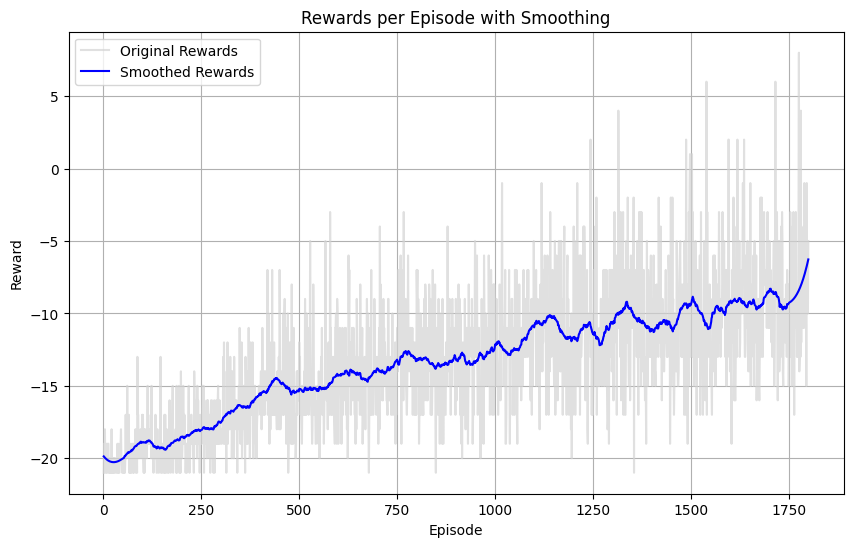

In [14]:
pong_rewards = np.load('rewards_base.npy')[0:1800]
smoothing_plot(pong_rewards, window = 99, save = False)

In [14]:
env = gym.make("Pong-v0")

RL_pong = PolicyGradient(6400,2,1e-3,1e-3,0.99)
RL_pong.p_net.load_state_dict(torch.load('/nfs/home/dxk9547/iems469/assignment1/model/p_model_episode_1900.pth'))
RL_pong.v_net.load_state_dict(torch.load('/nfs/home/dxk9547/iems469/assignment1/model/v_model_episode_1900.pth'))
rewards = []
stats_rewards_list = []
for episode in range(2000, 4000):
    # Initiate one episode
    observation, info = env.reset()
    episode_length = 0
    stats_actor_loss, stats_vf_loss = 0., 0.
    
    state_list, action_list, reward_list = [], [], []

    terminated = False
    truncated = False

    # Roll out one episode
    while (not terminated) and (not truncated):
        #action = env.action_space.sample() # Use your policy here
        observation = preprocess(observation)
        action = RL_pong.select_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action+2)

        # store agent's trajectory
        state_list.append(observation)
        action_list.append(action)
        reward_list.append(reward)
        
        observation = next_observation

    ep_rs_sum = sum(reward_list)

    if 'running_reward' not in globals():
        running_reward = ep_rs_sum
    else:
        running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
        
    actor_loss, vf_loss = RL_pong.train(state_list, action_list, reward_list)
    stats_rewards_list.append((episode, ep_rs_sum, episode_length))
    stats_actor_loss += actor_loss
    stats_vf_loss += vf_loss
    total_reward = 0
    episode_length = 0
    
    rewards.append(ep_rs_sum)
    if episode % 10 == 0:
        print('Episode: {}'.format(episode),
            'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-10:],axis=0)[1]),
            'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-10:],axis=0)[2]),
            'Actor Loss: {:.4f}'.format(stats_actor_loss/10), 
            'VF Loss: {:.4f}'.format(stats_vf_loss/10))
        stats_actor_loss, stats_vf_loss = 0., 0.
    if episode % 100 == 0:
        np.save('./rewards_base.npy', rewards)
        model_file_name_p = f"p_model_episode_{episode}.pth"
        model_file_name_v = f"v_model_episode_{episode}.pth"
        torch.save(RL_pong.p_net.state_dict(), '/nfs/home/dxk9547/iems469/assignment1/model/'+model_file_name_p)
        torch.save(RL_pong.v_net.state_dict(), '/nfs/home/dxk9547/iems469/assignment1/model/'+model_file_name_v)

Episode: 2000 Total reward: 5.0 Episode length: 0.0 Actor Loss: 0.0005 VF Loss: 0.0113
Episode: 2010 Total reward: -3.3 Episode length: 0.0 Actor Loss: -0.0003 VF Loss: 0.0080
Episode: 2020 Total reward: -4.4 Episode length: 0.0 Actor Loss: 0.0000 VF Loss: 0.0109
Episode: 2030 Total reward: -6.5 Episode length: 0.0 Actor Loss: -0.0002 VF Loss: 0.0125
Episode: 2040 Total reward: -5.3 Episode length: 0.0 Actor Loss: -0.0000 VF Loss: 0.0122
Episode: 2050 Total reward: -5.5 Episode length: 0.0 Actor Loss: -0.0001 VF Loss: 0.0146
Episode: 2060 Total reward: -3.9 Episode length: 0.0 Actor Loss: 0.0003 VF Loss: 0.0109
Episode: 2070 Total reward: -6.1 Episode length: 0.0 Actor Loss: -0.0008 VF Loss: 0.0105
Episode: 2080 Total reward: -5.3 Episode length: 0.0 Actor Loss: -0.0002 VF Loss: 0.0112
Episode: 2090 Total reward: -4.5 Episode length: 0.0 Actor Loss: -0.0002 VF Loss: 0.0096
Episode: 2100 Total reward: -6.7 Episode length: 0.0 Actor Loss: 0.0001 VF Loss: 0.0111
Episode: 2110 Total reward

KeyboardInterrupt: 

In [9]:
env = gym.make("Pong-v0")

RL_pong = PolicyGradient(6400,2,1e-3,1e-3,0.99)
RL_pong.p_net.load_state_dict(torch.load('/nfs/home/dxk9547/iems469/assignment1/model/p_model_episode_2800.pth'))
RL_pong.v_net.load_state_dict(torch.load('/nfs/home/dxk9547/iems469/assignment1/model/v_model_episode_2800.pth'))
RL_pong.p_net.eval()
RL_pong.v_net.eval()

test_rewards = []
for episode in range(500):
    # Initiate one episode
    observation, info = env.reset()
    reward_list = []
    
    terminated = False
    truncated = False

    # Roll out one episode
    while (not terminated) and (not truncated):
        observation = preprocess(observation)
        action = RL_pong.select_action(observation)
        next_observation, reward, terminated, truncated, _  = env.step(int(action)+2)
        
        observation = next_observation
        reward_list.append(reward)
    ep_rs_sum = sum(reward_list)
    test_rewards.append(ep_rs_sum)
    if episode % 10 == 0:
        print("Episode: {}".format(episode),
            'Total reward: {:.1f}'.format(np.mean(test_rewards[-10:])))
    
env.close()

/nfs/home/dxk9547/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Episode: 0 Total reward: -1.0
Episode: 10 Total reward: -3.5
Episode: 20 Total reward: -5.4
Episode: 30 Total reward: -3.2
Episode: 40 Total reward: -1.1
Episode: 50 Total reward: -1.4
Episode: 60 Total reward: -3.1
Episode: 70 Total reward: -1.5
Episode: 80 Total reward: -6.7
Episode: 90 Total reward: -1.7
Episode: 100 Total reward: 0.9
Episode: 110 Total reward: -0.2
Episode: 120 Total reward: -2.4
Episode: 130 Total reward: -4.8
Episode: 140 Total reward: -2.5
Episode: 150 Total reward: -2.0
Episode: 160 Total reward: -3.3
Episode: 170 Total reward: -4.3
Episode: 180 Total reward: -2.2
Episode: 190 Total reward: -0.4
Episode: 200 Total reward: -1.5
Episode: 210 Total reward: -1.1
Episode: 220 Total reward: -4.4
Episode: 230 Total reward: -3.0
Episode: 240 Total reward: -0.9
Episode: 250 Total reward: -1.1
Episode: 260 Total reward: -2.3
Episode: 270 Total reward: -5.0
Episode: 280 Total reward: -6.1
Episode: 290 Total reward: -3.2
Episode: 300 Total reward: -1.8
Episode: 310 Total r

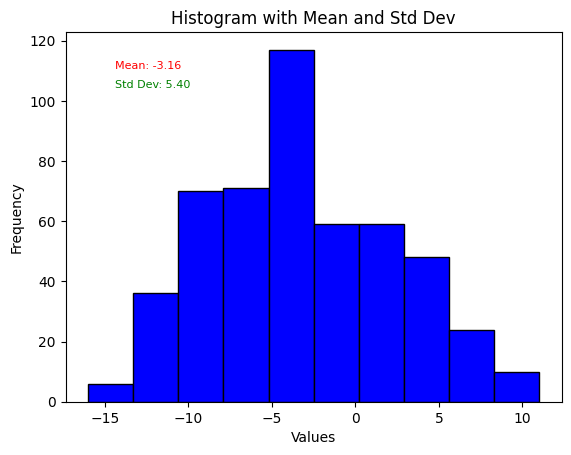

In [10]:
# Create a histogram
plt.hist(test_rewards, bins=10, color='blue', edgecolor='black')

# Calculate mean and standard deviation
mean = np.mean(test_rewards)
std_dev = np.std(test_rewards)

# Customize the histogram
plt.title('Histogram with Mean and Std Dev')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display mean and standard deviation as text labels on the plot
plt.text(0.1, 0.9, f'Mean: {mean:.2f}', fontsize=8, color='red', transform=plt.gca().transAxes)
plt.text(0.1, 0.85, f'Std Dev: {std_dev:.2f}', fontsize=8, color='green', transform=plt.gca().transAxes)

# Show the histogram
plt.show()